In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [72]:
def gen_xy(n=100):
    x = np.random.random([n,2]) # e.g. sin(y) + cos(x)
    return x, np.sin(x * np.pi * 2)

def f(phase=0, f=100):
    samples = np.arange(f) / f
    return np.sin(samples * np.pi * 2 + 2 * np.pi * phase)

In [73]:
n = 100
# x_train = np.stack([[f(p)] for p in np.random.random(n)])
# y_train = x_train
x_train, y_train = gen_xy(n)

In [74]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
hidden_layer_length = 10
x_train.shape

(1, 100, 2)

In [70]:
def decoder(input_length, output_length):
    input_layer = Input(shape=(input_length,))
    x = input_layer
#     x = Dense(2, activation='relu')(x)
#     x = Reshape((1,1))
    x = keras.layers.SimpleRNN(1, return_sequences = True)(x)
#     x = keras.layers.SimpleRNN(1)(x)
    x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

decoder = decoder(input_shape[0], output_shape[0])
decoder.summary()

ValueError: Input 0 is incompatible with layer simple_rnn_5: expected ndim=3, found ndim=2

In [32]:
metrics = ['accuracy','mse','binary_crossentropy']
loss = 'categorical_crossentropy'# binary_crossentropy categorical_crossentropy
optimizer = 'adadelta'
decoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
batch_size = 16
# n epochs = n iterations over all the training data
epochs = 9

In [34]:
# decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 833 samples, validate on 167 samples
Epoch 1/9
833/833 [==============================] - 0s 312us/step - loss: -1.3933 - acc: 0.6927 - mean_squared_error: 0.7617 - binary_crossentropy: 1.1224 - val_loss: -5.8685 - val_acc: 0.7425 - val_mean_squared_error: 0.7138 - val_binary_crossentropy: 2.0791
Epoch 2/9
833/833 [==============================] - 0s 173us/step - loss: -4.6728 - acc: 0.6903 - mean_squared_error: 0.7855 - binary_crossentropy: 3.2570 - val_loss: -7.0517 - val_acc: 0.7904 - val_mean_squared_error: 0.6697 - val_binary_crossentropy: 1.2295
Epoch 3/9
833/833 [==============================] - 0s 164us/step - loss: -7.0837 - acc: 0.7647 - mean_squared_error: 0.6858 - binary_crossentropy: 1.3582 - val_loss: -6.8100 - val_acc: 0.7305 - val_mean_squared_error: 0.6487 - val_binary_crossentropy: 1.0723
Epoch 4/9
833/833 [==============================] - 0s 163us/step - loss: -7.1000 - acc: 0.7611 - mean_squared_error: 0.6807 - binary_crossentropy: 1.4319 - val_loss: -6.

In [35]:
x_test, y_test = gen_xy(2)
x_test.shape

(2, 2)

In [36]:
decoder.predict(x_test)[0]

array([0., 1.], dtype=float32)

In [37]:
y_test[0]

array([-0.2772845 , -0.45010473])

In [38]:
x_test = np.stack([[x / 100, x] for x in np.arange(100)])
x_test.shape
result = decoder.predict(x_test)

In [39]:
result.shape

(100, 2)

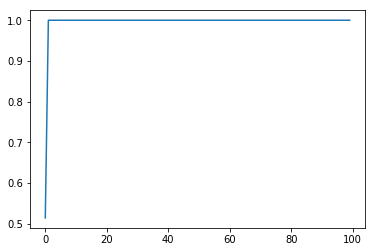

In [40]:
plt.plot(result[:,0])